<a href="https://colab.research.google.com/github/lucacamus13/equity-monitor-ARG/blob/main/Equity_valuation_ARG-TERMINADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install pandas matplotlib numpy yfinance

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Creando Argentina Equity Monitor agrupado por industria...
Obteniendo datos de Yahoo Finance...
Procesando BBAR.BA...
Procesando BMA.BA...
Procesando BYMA.BA...
Procesando METR.BA...
Procesando SUPV.BA...
Procesando TGNO4.BA...
Procesando TGSU2.BA...
Procesando VALO.BA...
Procesando YPFD.BA...
Procesando ALUA.BA...
Procesando TXAR.BA...
Procesando GGAL.BA...
Procesando PAMP.BA...
Procesando TECO2.BA...
Procesando EDN.BA...
Procesando COME.BA...
Procesando LOMA.BA...
Procesando TRAN.BA...
Procesando CRES.BA...
Procesando IRSA.BA...
Procesando CEPU.BA...

19-Jul-2025
ARGENTINA EQUITY MONITOR
Sector/Comp     Price      Var 1 W  Var 1 M  Var 1 Y  Var YTD  Beta   Market Cap   EV         EV/EBITDA  P/E      PV Sales PV BV  Oper Mgn  ROE      Vol. US$
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Aluminum                                                                          

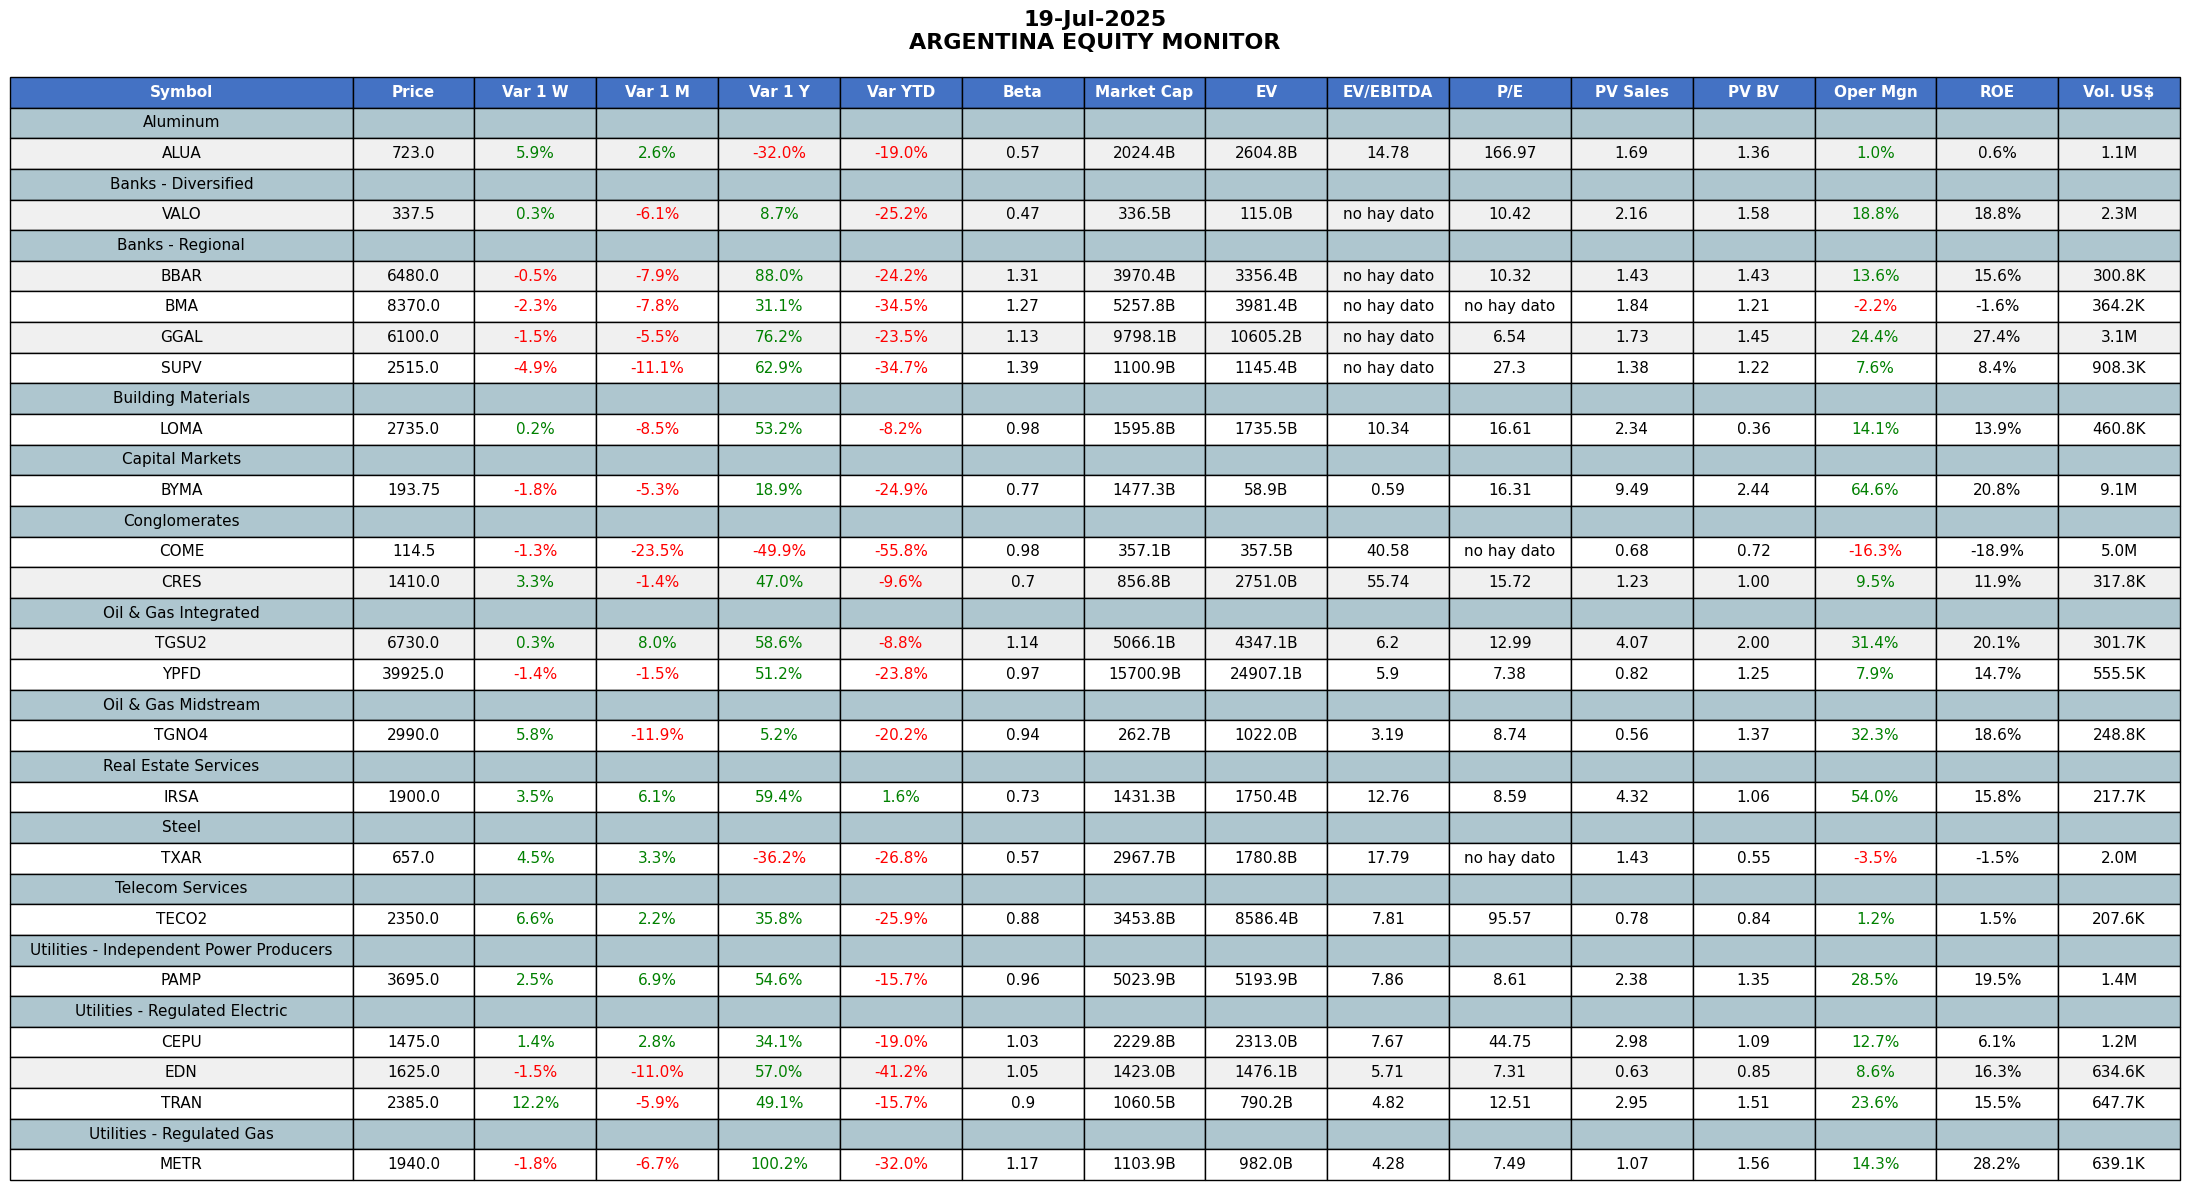


ESTADÍSTICAS POR INDUSTRIA

📊 ALUMINUM
--------------------------------------------------
Empresas: 1
Var 1 W: 5.90% promedio
Var 1 M: 2.60% promedio
Var 1 Y: -32.00% promedio
Var YTD: -19.00% promedio

📊 BANKS - DIVERSIFIED
--------------------------------------------------
Empresas: 1
Var 1 W: 0.30% promedio
Var 1 M: -6.10% promedio
Var 1 Y: 8.70% promedio
Var YTD: -25.20% promedio

📊 BANKS - REGIONAL
--------------------------------------------------
Empresas: 4
Var 1 W: -2.30% promedio
Var 1 M: -8.07% promedio
Var 1 Y: 64.55% promedio
Var YTD: -29.23% promedio

📊 BUILDING MATERIALS
--------------------------------------------------
Empresas: 1
Var 1 W: 0.20% promedio
Var 1 M: -8.50% promedio
Var 1 Y: 53.20% promedio
Var YTD: -8.20% promedio

📊 CAPITAL MARKETS
--------------------------------------------------
Empresas: 1
Var 1 W: -1.80% promedio
Var 1 M: -5.30% promedio
Var 1 Y: 18.90% promedio
Var YTD: -24.90% promedio

📊 CONGLOMERATES
--------------------------------------------

In [31]:
def get_stock_data(symbol):
    """
    Obtiene datos de una acción desde Yahoo Finance incluyendo información de industria
    """
    try:
        # Crear objeto ticker
        ticker = yf.Ticker(symbol)

        # Obtener información general
        info = ticker.info

        # Obtener datos históricos
        hist = ticker.history(period="1y") # Still getting 1y for other calculations

        if hist.empty:
            return None

        # Calcular variaciones
        current_price = hist['Close'].iloc[-1]

        # Variación semanal (7 días)
        try:
            week_ago_price = hist['Close'].iloc[-7]
            var_1w = ((current_price - week_ago_price) / week_ago_price) * 100
        except:
            var_1w = "no hay dato"

        # Variación mensual (30 días)
        try:
            month_ago_price = hist['Close'].iloc[-30]
            var_1m = ((current_price - month_ago_price) / month_ago_price) * 100
        except:
            var_1m = "no hay dato"

        # Variación anual (365 días o lo que esté disponible)
        try:
            year_ago_price = hist['Close'].iloc[0]
            var_1y = ((current_price - year_ago_price) / year_ago_price) * 100
        except:
            var_1y = "no hay dato"

        # Calcular variación YTD (Year To Date)
        var_ytd = "no hay dato"
        try:
            # Get data from the beginning of the current year
            start_of_year = datetime(datetime.now().year, 1, 1)
            ytd_hist = ticker.history(start=start_of_year, end=datetime.now())

            if not ytd_hist.empty:
                # Find the first trading day of the year
                first_day_price = ytd_hist['Close'].iloc[0]
                if first_day_price:
                    var_ytd = ((current_price - first_day_price) / first_day_price) * 100
                else:
                    var_ytd = "no hay dato"
            else:
                # If no data for the current year, try getting data including end of last year
                end_of_last_year = datetime(datetime.now().year - 1, 12, 31)
                longer_hist = ticker.history(start=end_of_last_year - timedelta(days=7), end=datetime.now()) # Get a week before year end
                if not longer_hist.empty:
                    # Find the last trading day of the previous year
                    last_day_last_year_data = longer_hist[longer_hist.index.year == (datetime.now().year - 1)]
                    if not last_day_last_year_data.empty:
                        last_day_last_year_price = last_day_last_year_data['Close'].iloc[-1]
                        if last_day_last_year_price:
                             var_ytd = ((current_price - last_day_last_year_price) / last_day_last_year_price) * 100
                        else:
                             var_ytd = "no hay dato"
                    else:
                         var_ytd = "no hay dato"
                else:
                     var_ytd = "no hay dato"

        except Exception as e:
             print(f"Error calculando YTD para {symbol}: {e}")
             var_ytd = "no hay dato"


        # Calcular beta (correlación con el mercado)
        try:
            # Obtener datos del MERVAL como benchmark
            merval = yf.Ticker("^MERV")
            merval_hist = merval.history(period="1y")

            if not merval_hist.empty and len(hist) == len(merval_hist):
                stock_returns = hist['Close'].pct_change().dropna()
                market_returns = merval_hist['Close'].pct_change().dropna()

                if len(stock_returns) > 1 and len(market_returns) > 1:
                    covariance = np.cov(stock_returns, market_returns)[0][1]
                    market_variance = np.var(market_returns)
                    beta = covariance / market_variance if market_variance != 0 else "no hay dato"
                else:
                    beta = "no hay dato"
            else:
                beta = "no hay dato"
        except:
            beta = "no hay dato"

        # Extraer información de industria y sector
        industry = info.get('industry', 'no hay dato')
        sector = info.get('sector', 'no hay dato')

        # Extraer datos financieros del info
        market_cap = info.get('marketCap', 'no hay dato')
        enterprise_value = info.get('enterpriseValue', 'no hay dato')
        ev_ebitda = info.get('enterpriseToEbitda', 'no hay dato')
        pe_ratio = info.get('trailingPE', 'no hay dato')
        price_to_sales = info.get('priceToSalesTrailing12Months', 'no hay dato')
        price_to_book = info.get('priceToBook', 'no hay dato')
        profit_margin = info.get('profitMargins', 'no hay dato')
        roe = info.get('returnOnEquity', 'no hay dato')
        avg_volume = info.get('averageVolume', 'no hay dato')

        # Formatear datos
        return {
            'symbol': symbol,
            'company_name': info.get('shortName', symbol.replace('.BA', '')),
            'sector': sector,
            'industry': industry,
            'price': round(current_price, 2) if current_price else "no hay dato",
            'var_1w': f"{var_1w:.1f}%" if isinstance(var_1w, (int, float)) else var_1w,
            'var_1m': f"{var_1m:.1f}%" if isinstance(var_1m, (int, float)) else var_1m,
            'var_1y': f"{var_1y:.1f}%" if isinstance(var_1y, (int, float)) else var_1y,
            'var_ytd': f"{var_ytd:.1f}%" if isinstance(var_ytd, (int, float)) else var_ytd, # Add YTD
            'beta': round(beta, 2) if isinstance(beta, (int, float)) else beta,
            'market_cap': market_cap,
            'enterprise_value': enterprise_value,
            'ev_ebitda': round(ev_ebitda, 2) if isinstance(ev_ebitda, (int, float)) else ev_ebitda,
            'pe_ratio': round(pe_ratio, 2) if isinstance(pe_ratio, (int, float)) else pe_ratio,
            'price_to_sales': round(price_to_sales, 2) if isinstance(price_to_sales, (int, float)) else price_to_sales,
            'price_to_book': round(price_to_book, 2) if isinstance(price_to_book, (int, float)) else price_to_book,
            'profit_margin': f"{profit_margin*100:.1f}%" if isinstance(profit_margin, (int, float)) else profit_margin,
            'roe': f"{roe*100:.1f}%" if isinstance(roe, (int, float)) else roe,
            'avg_volume': avg_volume
        }

    except Exception as e:
        print(f"Error obteniendo datos para {symbol}: {e}")
        return None

def format_large_numbers(value):
    """Formatear números grandes"""
    if isinstance(value, (int, float)):
        if value >= 1000000000:
            return f"{value/1000000000:.1f}B"
        elif value >= 1000000:
            return f"{value/1000000:.1f}M"
        elif value >= 1000:
            return f"{value/1000:.1f}K"
        else:
            return f"{value:.2f}"
    return value

def create_grouped_equity_monitor(symbols):
    """
    Crear el monitor de acciones argentinas con filas agrupadas por industria
    """
    print("Obteniendo datos de Yahoo Finance...")
    print("=" * 50)

    all_data = []

    for symbol in symbols:
        print(f"Procesando {symbol}...")
        stock_data = get_stock_data(symbol)

        if stock_data:
            all_data.append({
                'Symbol': symbol.replace('.BA', ''),
                'Company': stock_data['company_name'],
                'Sector': stock_data['sector'],
                'Industry': stock_data['industry'],
                'Price': stock_data['price'],
                'Var 1 W': stock_data['var_1w'],
                'Var 1 M': stock_data['var_1m'],
                'Var 1 Y': stock_data['var_1y'],
                'Var YTD': stock_data['var_ytd'], # Add YTD
                'Beta': stock_data['beta'],
                'Market Cap': format_large_numbers(stock_data['market_cap']),
                'EV': format_large_numbers(stock_data['enterprise_value']),
                'EV/EBITDA': stock_data['ev_ebitda'],
                'P/E': stock_data['pe_ratio'],
                'PV Sales': format_large_numbers(stock_data['price_to_sales']),
                'PV BV': format_large_numbers(stock_data['price_to_book']),
                'Oper Mgn': stock_data['profit_margin'],
                'ROE': stock_data['roe'],
                'Vol. US$': format_large_numbers(stock_data['avg_volume'])
            })
        else:
            # Si no se pueden obtener datos, llenar con "no hay dato"
            all_data.append({
                'Symbol': symbol.replace('.BA', ''),
                'Company': 'no hay dato',
                'Sector': 'no hay dato',
                'Industry': 'no hay dato',
                'Price': 'no hay dato',
                'Var 1 W': 'no hay dato',
                'Var 1 M': 'no hay dato',
                'Var 1 Y': 'no hay dato',
                'Var YTD': 'no hay dato', # Add YTD
                'Beta': 'no hay dato',
                'Market Cap': 'no hay dato',
                'EV': 'no hay dato',
                'EV/EBITDA': 'no hay dato',
                'P/E': 'no hay dato',
                'PV Sales': 'no hay dato',
                'PV BV': 'no hay dato',
                'Oper Mgn': 'no hay dato',
                'ROE': 'no hay dato',
                'Vol. US$': 'no hay dato'
            })

    df = pd.DataFrame(all_data)

    # Ordenar por industria y luego por símbolo
    df = df.sort_values(['Industry', 'Symbol']).reset_index(drop=True)

    return df

def display_grouped_table(df):
    """
    Mostrar tabla con filas agrupadas por industria (texto)
    """
    print(f"\n{datetime.now().strftime('%d-%b-%Y')}")
    print("ARGENTINA EQUITY MONITOR")
    print("=" * 120)

    # Columns to display - Added 'Var YTD'
    display_cols = ['Symbol', 'Price', 'Var 1 W', 'Var 1 M', 'Var 1 Y', 'Var YTD', 'Beta', 'Market Cap', 'EV', 'EV/EBITDA', 'P/E', 'PV Sales', 'PV BV', 'Oper Mgn', 'ROE', 'Vol. US$']


    # Header - Added space for 'Var YTD'
    header = f"{'Sector/Comp':<15} {'Price':<10} {'Var 1 W':<8} {'Var 1 M':<8} {'Var 1 Y':<8} {'Var YTD':<8} {'Beta':<6} {'Market Cap':<12} {'EV':<10} {'EV/EBITDA':<10} {'P/E':<8} {'PV Sales':<8} {'PV BV':<6} {'Oper Mgn':<9} {'ROE':<8} {'Vol. US$':<8}"
    print(header)
    print("-" * (len(header) + 5)) # Adjusted separator length based on header

    # Crear tabla con separadores por industria
    current_industry = None

    for idx, row in df.iterrows():
        # If industry changes or it's the first row and has a valid industry, show separator
        if (row['Industry'] != current_industry and row['Industry'] != 'no hay dato') or (idx == 0 and row['Industry'] != 'no hay dato'):
            if current_industry is not None:  # No mostrar separador antes del primer grupo si ya se mostró uno
                 print()

            # Mostrar nombre de la industria como separador
            industry_name = row['Industry']
            if len(industry_name) > 30:
                industry_name = industry_name[:27] + "..."

            # Added space for 'Var YTD' in separator row
            print(f"{industry_name:<15} {'':<10} {'':<8} {'':<8} {'':<8} {'':<8} {'':<6} {'':<12} {'':<10} {'':<10} {'':<8} {'':<8} {'':<6} {'':<9} {'':<8} {'':<8}")
            current_industry = row['Industry']

        # Mostrar fila de datos - Added var_ytd
        symbol = row['Symbol']
        price = str(row['Price'])
        var_1w = str(row['Var 1 W'])
        var_1m = str(row['Var 1 M'])
        var_1y = str(row['Var 1 Y'])
        var_ytd = str(row['Var YTD']) # Get YTD value
        beta = str(row['Beta'])
        market_cap = str(row['Market Cap'])
        ev = str(row['EV'])
        ev_ebitda = str(row['EV/EBITDA'])
        pe = str(row['P/E'])
        pv_sales = str(row['PV Sales'])
        pv_bv = str(row['PV BV'])
        oper_mgn = str(row['Oper Mgn'])
        roe = str(row['ROE'])
        vol_us = str(row['Vol. US$'])

        # Added var_ytd to the print format
        print(f"{symbol:<15} {price:<10} {var_1w:<8} {var_1m:<8} {var_1y:<8} {var_ytd:<8} {beta:<6} {market_cap:<12} {ev:<10} {ev_ebitda:<10} {pe:<8} {pv_sales:<8} {pv_bv:<6} {oper_mgn:<9} {roe:<8} {vol_us:<8}")

def create_visual_grouped_table(df):
    """
    Crear tabla visual con matplotlib agrupada por industria
    """
    fig, ax = plt.subplots(figsize=(22, 12)) # Increased figure width
    ax.axis('tight')
    ax.axis('off')

    # Preparar datos para la tabla visual
    table_data = []
    cell_colors = [] # Keep cell colors for background (e.g., alternating rows)
    text_colors = [] # New list for text colors

    # Columns to display - Added 'Var YTD'
    columns = ['Symbol', 'Price', 'Var 1 W', 'Var 1 M', 'Var 1 Y', 'Var YTD', 'Beta', 'Market Cap', 'EV', 'EV/EBITDA', 'P/E', 'PV Sales', 'PV BV', 'Oper Mgn', 'ROE', 'Vol. US$']

    current_industry = None
    row_background_color_idx = 0 # Index for alternating row background colors

    for idx, row in df.iterrows():
        # If industry changes or it's the first row and has a valid industry, add separator row
        if (row['Industry'] != current_industry and row['Industry'] != 'no hay dato') or (idx == 0 and row['Industry'] != 'no hay dato'):
            # Add separator row for the new industry
            separator_row = [row['Industry']] + [''] * (len(columns) - 1)
            table_data.append(separator_row)
            cell_colors.append(['#AEC6CF'] * len(columns))  # Light blue for separators
            text_colors.append(['black'] * len(columns)) # Black text for separators
            row_background_color_idx += 1 # Increment for the separator row

            current_industry = row['Industry']

        # Add data row - Added Var YTD
        data_row = [
            row['Symbol'],
            str(row['Price']),
            str(row['Var 1 W']),
            str(row['Var 1 M']),
            str(row['Var 1 Y']),
            str(row['Var YTD']), # Add YTD value
            str(row['Beta']),
            str(row['Market Cap']),
            str(row['EV']),
            str(row['EV/EBITDA']),
            str(row['P/E']),
            str(row['PV Sales']),
            str(row['PV BV']),
            str(row['Oper Mgn']),
            str(row['ROE']),
            str(row['Vol. US$'])
        ]

        table_data.append(data_row)

        # Apply alternating row background colors
        if row_background_color_idx % 2 == 0:
            background_color = 'white'
        else:
            background_color = '#f0f0f0'
        row_background_color = [background_color] * len(columns)
        cell_colors.append(row_background_color)

        # Determine text colors based on values
        row_text_color = ['black'] * len(columns) # Default text color is black

        # Color text for variation and ROE columns - Added index for Var YTD (5)
        for i, val in enumerate(data_row):
            if i in [2, 3, 4, 5, 12, 13]:  # Columns for Var 1 W, Var 1 M, Var 1 Y, Var YTD, Oper Mgn, ROE
                if isinstance(val, str) and '%' in val and val != 'no hay dato':
                    try:
                        value = float(val.replace('%', ''))
                        if value > 0:
                            row_text_color[i] = 'green'  # Green text for positive values
                        elif value < 0:
                            row_text_color[i] = 'red' # Red text for negative values
                        # No change for 0 or 'no hay dato' (black text)
                    except:
                        pass # Keep default black text for parsing errors

        text_colors.append(row_text_color)
        row_background_color_idx += 1 # Increment for the data row


    #Anchos de las columnas, suma debe ser 1
    col_widths = [0.15] + [0.8 / (len(columns) - 1)] * (len(columns) - 1)


    # Create the table
    table = ax.table(cellText=table_data,
                    colLabels=columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1],
                     colWidths=col_widths)


    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 1.8)

    # Header colors
    header_color = '#4472C4'
    for i in range(len(columns)):
        table[(0, i)].set_facecolor(header_color)
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Apply cell background colors and text colors
    for i in range(len(table_data)):
        for j in range(len(columns)):
            table[(i+1, j)].set_facecolor(cell_colors[i][j])
            table[(i+1, j)].get_text().set_color(text_colors[i][j])
            # If it's a separator row (industry), make text bold
            if cell_colors[i][j] == '#ADD8E6':
                 table[(i+1, j)].get_text().set_weight('bold')


    # Title
    title = f"{datetime.now().strftime('%d-%b-%Y')}\nARGENTINA EQUITY MONITOR"
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def get_industry_statistics(df):
    """
    Obtener estadísticas por industria
    """
    print("\n" + "="*80)
    print("ESTADÍSTICAS POR INDUSTRIA")
    print("="*80)

    industries = df['Industry'].unique()
    industries = [ind for ind in industries if ind != 'no hay dato']

    for industry in industries:
        industry_data = df[df['Industry'] == industry]

        print(f"\n📊 {industry.upper()}")
        print("-" * 50)
        print(f"Empresas: {len(industry_data)}")

        # Calcular promedios de rendimiento - Added 'Var YTD'
        for period in ['Var 1 W', 'Var 1 M', 'Var 1 Y', 'Var YTD']:
            valid_values = []
            for val in industry_data[period]:
                if isinstance(val, str) and '%' in val and val != 'no hay dato':
                    try:
                        valid_values.append(float(val.replace('%', '')))
                    except:
                        pass

            if valid_values:
                avg = np.mean(valid_values)
                print(f"{period}: {avg:.2f}% promedio")

# Lista de símbolos de acciones argentinas
symbols = [
    'BBAR.BA',   #Banco Frances
    'BMA.BA',    # Banco Macro
    'BYMA.BA',   # Bolsas y Mercados Argentina
    'METR.BA',   # Metrogas
    'SUPV.BA',   # Banco Supervielle
    'TGNO4.BA',  # Transporte Gas del Norte
    'TGSU2.BA',  # Transporte Gas del Sur
    'VALO.BA',   # Mercado de Valores de Buenos Aires
    'YPFD.BA',   # YPF
    'ALUA.BA',   # Aluar
    'TXAR.BA',   # Ternium Argentina
    'GGAL.BA',   # Grupo Galicia
    'PAMP.BA',   # Pampa Energía
    'TECO2.BA',  # Telecom Argentina
    'EDN.BA',   # Edenor
    'COME.BA',   # Comercial del Plata
    'LOMA.BA',   # Loma Negra
    'TRAN.BA',   # Transener
    'CRES.BA',   # Cresud
    'IRSA.BA',   # IRSA
    'CEPU.BA',   # Central Puerto
]

# Crear el monitor
print("Creando Argentina Equity Monitor agrupado por industria...")
df = create_grouped_equity_monitor(symbols)

# Mostrar tabla agrupada (texto)
display_grouped_table(df)

# Mostrar tabla visual
create_visual_grouped_table(df)

# Mostrar estadísticas por industria
get_industry_statistics(df)

# Función para actualizar
def update_grouped_monitor():
    """Actualizar el monitor agrupado"""
    global df
    print("Actualizando datos...")
    df = create_grouped_equity_monitor(symbols)
    display_grouped_table(df)
    return df

print("\n" + "="*80)
print("INSTRUCCIONES:")
print("="*80)
print("1. Para actualizar: update_grouped_monitor()")
print("2. Para ver estadísticas: get_industry_statistics(df)")
print("3. Para agregar símbolos: symbols.append('NUEVO.BA')")
print("4. Los datos se agrupan automáticamente por industria")

# Guardar en Excel

In [14]:
# Guardar el DataFrame como archivo Excel en Colab
excel_filename = 'argentina_equity_monitor.xlsx'
df.to_excel(excel_filename, index=False) # index=False para no guardar el índice del DataFrame

print(f"DataFrame guardado exitosamente en {excel_filename}")

DataFrame guardado exitosamente en argentina_equity_monitor.xlsx


# Top Semanal

## Top Mejores

In [32]:
# Filtrar las filas con datos válidos en 'Var 1 W'
valid_var_1w_df = df[df['Var 1 W'] != 'no hay dato'].copy()

# Convertir la columna 'Var 1 W' a numérica (quitando el '%' y convirtiendo a float)
valid_var_1w_df['Var 1 W_numeric'] = valid_var_1w_df['Var 1 W'].str.replace('%', '').astype(float)

# Ordenar por la variación semanal de forma descendente
top_gainers_1w = valid_var_1w_df.sort_values(by='Var 1 W_numeric', ascending=False)

# Seleccionar los top 10 (o menos si hay menos de 10)
top_n = 10
top_gainers_1w = top_gainers_1w.head(top_n)

display(top_gainers_1w[['Symbol', 'Company', 'Var 1 W']].reset_index(drop=True))

,Symbol,Company,Var 1 W
0,TRAN,CIA DE TRANSP DE ENERGIA ELECTR,12.2%
1,TECO2,TELECOM ARGENTINA SA,6.6%
2,ALUA,ALUAR ALUMINIO ARGENTINA SA,5.9%
3,TGNO4,TRANSPORTADORA DE GAS DEL NORTE,5.8%
4,TXAR,TERNIUM ARGENTINA SA,4.5%
5,IRSA,IRSA INVERSIONES Y REPRESENTACI,3.5%
6,CRES,CRESUD S.A.C.I.F.Y.A.,3.3%
7,PAMP,PAMPA ENERGIA S.A.,2.5%
8,CEPU,CENTRAL PUERTO SA,1.4%
9,TGSU2,TRANSPORTADORA DE GAS DEL SUR S,0.3%


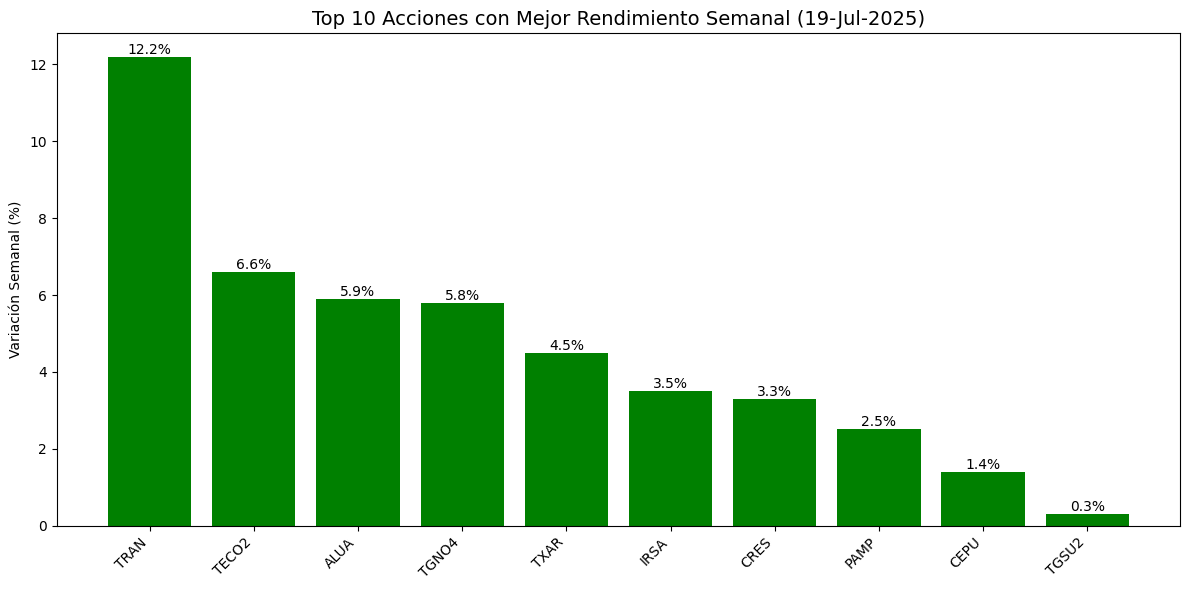

In [33]:
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(top_gainers_1w['Symbol'], top_gainers_1w['Var 1 W_numeric'], color='green')

# Añadir etiquetas y título
plt.ylabel('Variación Semanal (%)')
plt.title(f'Top {len(top_gainers_1w)} Acciones con Mejor Rendimiento Semanal ({datetime.now().strftime("%d-%b-%Y")})', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Añadir el valor de la barra encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.tight_layout() # Ajustar el layout para evitar cortar etiquetas
plt.show()

## Top peores

In [17]:
# Ordenar por la variación semanal de forma ascendente (para obtener los peores)
top_losers_1w = valid_var_1w_df.sort_values(by='Var 1 W_numeric', ascending=True)

# Seleccionar los top 10 (o menos si hay menos de 10)
top_n = 10
top_losers_1w = top_losers_1w.head(top_n)

display(top_losers_1w[['Symbol', 'Company', 'Var 1 W']].reset_index(drop=True))

,Symbol,Company,Var 1 W
0,AGRO,AGROMETAL SA,-5.0%
1,SUPV,GRUPO SUPERVIELLE S.A.,-4.9%
2,HAVA,HAVANNA HOLDING SA,-4.8%
3,GGAL,GRUPO FINANCIERO GALICIA SA,-1.5%
4,EDN,EMPRESA DISTR Y COMERC NORTE ED,-1.5%
5,YPFD,YPF SOCIEDAD ANONIMA,-1.4%
6,COME,SOCIEDAD COMERCIAL DEL PLATA,-1.3%
7,BBAR,BANCO BBVA ARGENTINA S A,-0.5%
8,DYCA,DYCASA SA,0.0%
9,LOMA,LOMA NEGRA CIA IND ARGENTINA SA,0.2%


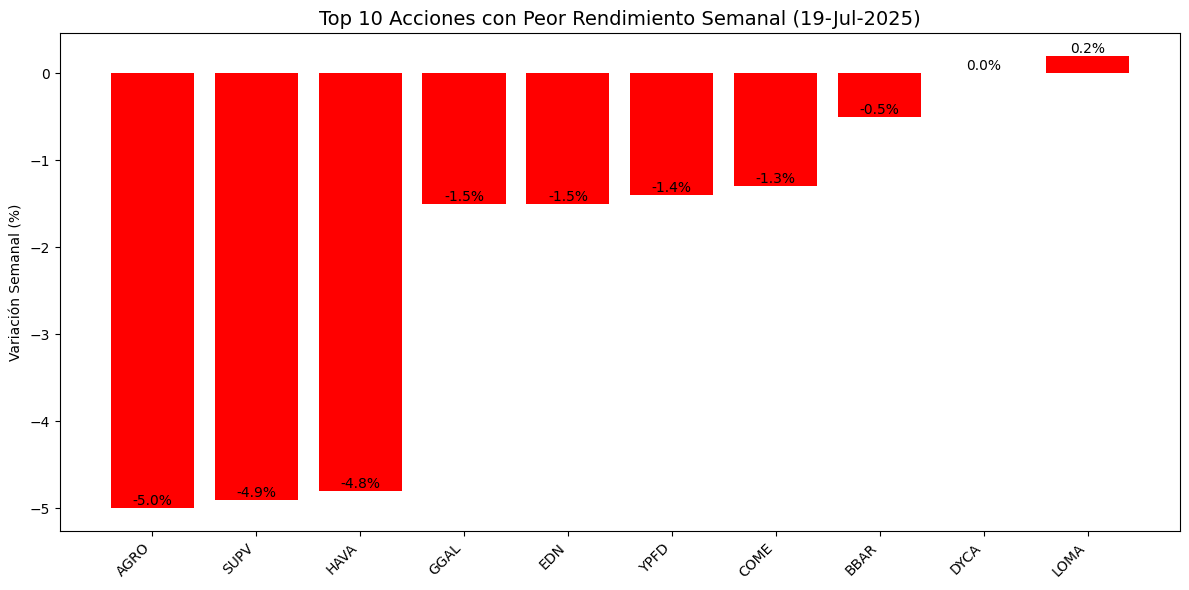

In [18]:
# Crear el gráfico de barras para los peores rendimientos
plt.figure(figsize=(12, 6))
bars = plt.bar(top_losers_1w['Symbol'], top_losers_1w['Var 1 W_numeric'], color='red')

# Añadir etiquetas y título
plt.ylabel('Variación Semanal (%)')
plt.title(f'Top {len(top_losers_1w)} Acciones con Peor Rendimiento Semanal ({datetime.now().strftime("%d-%b-%Y")})', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Añadir el valor de la barra encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment


plt.tight_layout() # Ajustar el layout para evitar cortar etiquetas
plt.show()

## Top industria

In [20]:
# Calcular la variación semanal promedio ponderada por market cap por industria
industry_weighted_weekly_var = {}

for industry in df['Industry'].unique():
    if industry == 'no hay dato':
        continue

    industry_data = df[df['Industry'] == industry].copy() # Create a copy to avoid SettingWithCopyWarning

    # Convert 'Market Cap' to numeric, handling 'B', 'M', 'K' suffixes
    def convert_market_cap(value):
        if isinstance(value, str):
            value = value.strip()
            if value.endswith('B'):
                return float(value[:-1]) * 1_000_000_000
            elif value.endswith('M'):
                return float(value[:-1]) * 1_000_000
            elif value.endswith('K'):
                return float(value[:-1]) * 1_000
            else:
                try:
                    return float(value)
                except ValueError:
                    return 0.0 # Handle cases where conversion fails
        elif isinstance(value, (int, float)):
            return float(value)
        return 0.0

    industry_data.loc[:, 'Market Cap_numeric'] = industry_data['Market Cap'].apply(convert_market_cap)


    # Filter for valid weekly variation and market cap data
    valid_data = industry_data[(industry_data['Var 1 W'] != 'no hay dato') & (industry_data['Market Cap_numeric'] > 0)]

    if not valid_data.empty:
        # Convert variation to numeric
        valid_data.loc[:, 'Var 1 W_numeric'] = valid_data['Var 1 W'].str.replace('%', '').astype(float)

        # Calculate weighted average
        # Weighted average = Sum(variation * market cap) / Sum(market cap)
        sum_of_weighted_variations = (valid_data['Var 1 W_numeric'] * valid_data['Market Cap_numeric']).sum()
        sum_of_market_caps = valid_data['Market Cap_numeric'].sum()

        if sum_of_market_caps > 0:
            weighted_avg_var = sum_of_weighted_variations / sum_of_market_caps
            industry_weighted_weekly_var[industry] = weighted_avg_var
        else:
            industry_weighted_weekly_var[industry] = 0.0 # Or np.nan if preferred

# Convertir el diccionario a un DataFrame para facilitar el manejo
industry_var_df = pd.DataFrame(list(industry_weighted_weekly_var.items()), columns=['Industry', 'Weighted Avg Var 1 W'])

# Ordenar para obtener los mejores y peores
industry_var_df = industry_var_df.sort_values(by='Weighted Avg Var 1 W', ascending=False)

# Seleccionar el top N mejores y peores industrias
top_n_industries = 5 # Puedes ajustar este número
top_gainers_industries = industry_var_df.head(top_n_industries)
top_losers_industries = industry_var_df.tail(top_n_industries).sort_values(by='Weighted Avg Var 1 W', ascending=False) # Mantener el orden descendente para el gráfico

# Combinar los dataframes para graficar
industries_to_plot = pd.concat([top_gainers_industries, top_losers_industries])

display(industries_to_plot)

,Industry,Weighted Avg Var 1 W
12,Telecom Services,6.600000
0,Aluminum,5.900000
11,Steel,4.500000
4,Consumer Electronics,3.500000
9,Real Estate Services,3.500000
5,Engineering & Construction,0.000000
7,Oil & Gas Integrated,-0.985286
1,Banks - Regional,-1.484711
10,Restaurants,-4.800000
6,Farm & Heavy Construction Machinery,-5.000000


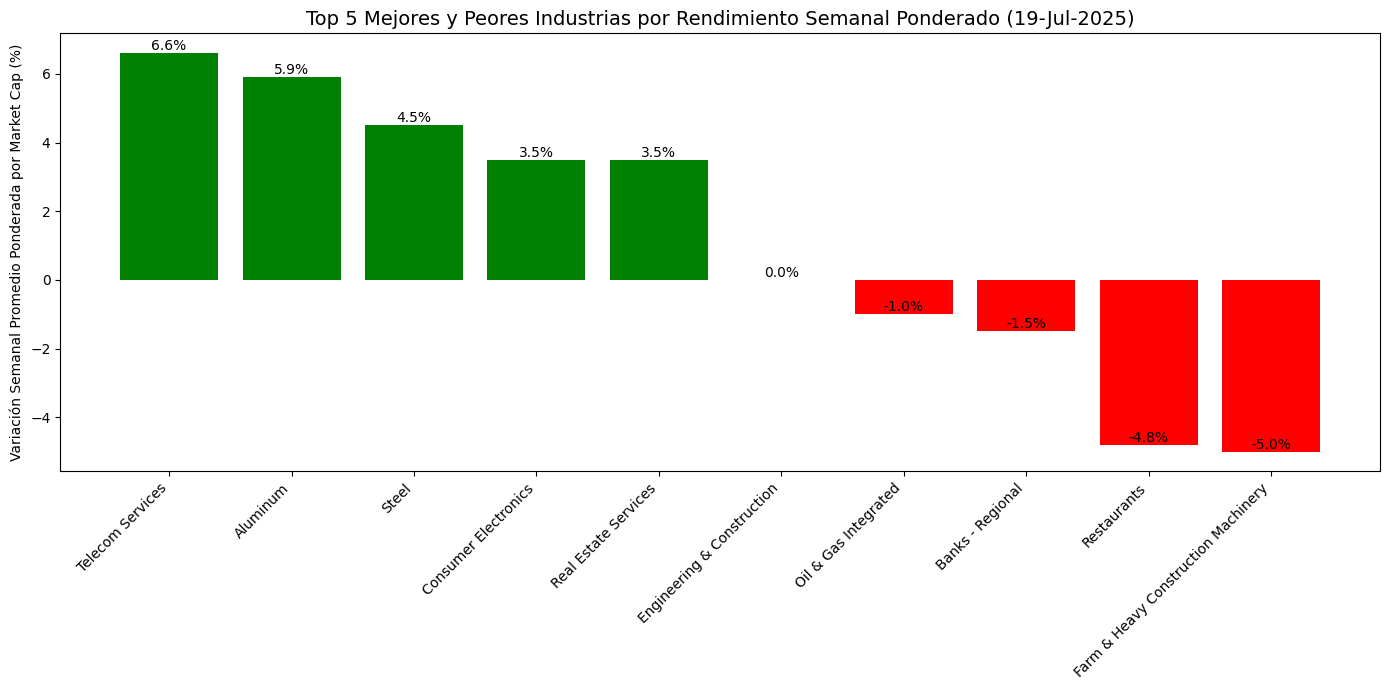

In [21]:
# Crear el gráfico de barras para las mejores y peores industrias (ponderado por Market Cap)
plt.figure(figsize=(14, 7))
bars = plt.bar(industries_to_plot['Industry'], industries_to_plot['Weighted Avg Var 1 W'], # Use the new weighted average column
               color=['green' if x > 0 else 'red' for x in industries_to_plot['Weighted Avg Var 1 W']]) # Use the new weighted average column

# Añadir etiquetas y título
plt.ylabel('Variación Semanal Promedio Ponderada por Market Cap (%)') # Update label
plt.title(f'Top {top_n_industries} Mejores y Peores Industrias por Rendimiento Semanal Ponderado ({datetime.now().strftime("%d-%b-%Y")})', fontsize=14) # Update title
plt.xticks(rotation=45, ha='right')

# Añadir el valor de la barra encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.tight_layout() # Ajustar el layout para evitar cortar etiquetas
plt.show()

## Mayor volumen operado diario

In [25]:
# Filtrar las filas con datos válidos en 'Vol. US$'
valid_volume_df = df[df['Vol. US$'] != 'no hay dato'].copy()

# Convertir la columna 'Vol. US$' a numérica
valid_volume_df.loc[:, 'Vol_numeric'] = valid_volume_df['Vol. US$'].apply(lambda x: float(x.replace('B', 'e9').replace('M', 'e6').replace('K', 'e3')))

# Ordenar por volumen de forma descendente
top_volume = valid_volume_df.sort_values(by='Vol_numeric', ascending=False)

# Seleccionar los top 10 (o menos si hay menos de 10)
top_n = 10
top_volume = top_volume.head(top_n)

display(top_volume[['Symbol', 'Company', 'Vol. US$']].reset_index(drop=True))

,Symbol,Company,Vol. US$
0,COME,SOCIEDAD COMERCIAL DEL PLATA,5.0M
1,GGAL,GRUPO FINANCIERO GALICIA SA,3.1M
2,TXAR,TERNIUM ARGENTINA SA,2.0M
3,AGRO,AGROMETAL SA,1.9M
4,PAMP,PAMPA ENERGIA S.A.,1.4M
5,CEPU,CENTRAL PUERTO SA,1.2M
6,ALUA,ALUAR ALUMINIO ARGENTINA SA,1.1M
7,SUPV,GRUPO SUPERVIELLE S.A.,908.3K
8,TRAN,CIA DE TRANSP DE ENERGIA ELECTR,647.7K
9,EDN,EMPRESA DISTR Y COMERC NORTE ED,634.6K


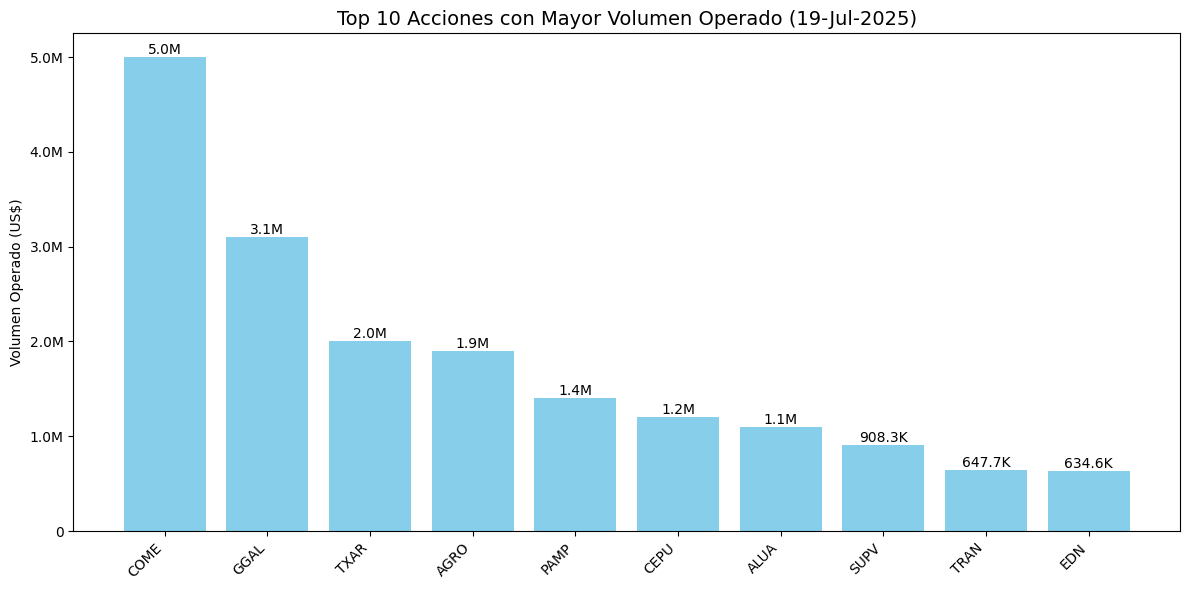

In [26]:
# Crear el gráfico de barras para el top 10 por volumen
plt.figure(figsize=(12, 6))
bars = plt.bar(top_volume['Symbol'], top_volume['Vol_numeric'], color='skyblue')

# Añadir etiquetas y título
plt.ylabel('Volumen Operado (US$)')
plt.title(f'Top {len(top_volume)} Acciones con Mayor Volumen Operado ({datetime.now().strftime("%d-%b-%Y")})', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Formatear las etiquetas del eje y para mostrar números grandes de forma legible
def format_volume_labels(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    elif x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    return f'{x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_volume_labels))


# Añadir el valor de la barra encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, format_large_numbers(yval), va='bottom', ha='center') # Reusing the format_large_numbers function


plt.tight_layout() # Ajustar el layout para evitar cortar etiquetas
plt.show()

,Symbol,Company,Vol. US$
0,COME,SOCIEDAD COMERCIAL DEL PLATA,5.0M
1,GGAL,GRUPO FINANCIERO GALICIA SA,3.1M
2,TXAR,TERNIUM ARGENTINA SA,2.0M
3,AGRO,AGROMETAL SA,1.9M
4,PAMP,PAMPA ENERGIA S.A.,1.4M
5,CEPU,CENTRAL PUERTO SA,1.2M
6,ALUA,ALUAR ALUMINIO ARGENTINA SA,1.1M
7,SUPV,GRUPO SUPERVIELLE S.A.,908.3K
8,TRAN,CIA DE TRANSP DE ENERGIA ELECTR,647.7K
9,EDN,EMPRESA DISTR Y COMERC NORTE ED,634.6K
